## <font style = "color:rgb(50,120,229)">Happify Filter</font>

In the Happify filter, the deformation points in the original image are shown in red and the corresponding points in the deformed image are shown in blue. See Figure 2 below. The blue control points in the upper part of the face are calculated by extending the line joining a point on the bridge of the nose to the red control points by an offset. Similarly, the blue control points  on the lower half of the face are calculated by extending the line joining the chin to the red control points by an offset value. 

The anchor points are shown in green in Figure 2. 

| <center><a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-deformatedRedPoints.png"><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-deformatedRedPoints.png" width=500/></a></center> | <center><a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-anchorPoints.png"><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-anchorPoints.png" width=500/></a></center> | 
| -------- | -------- |

<center>Figure 2 : Left: The deformation of the red points ( shown using blue points ) is calculated by extending the link joining the yellow points to the red points by an offset. </center>

Right: Green points represent anchor points. The red points represent deformation points in the input image. The blue points represent the corresponding deformed points in the output image. 



### <font style = "color:rgb(8,133,37)">Happify Code and Tutorial</font>

The following tutorial shows Happify filter for an image. The code for videos is similar and is included in the code section. 

In [1]:
#include "includeLibraries.h"
#include "matplotlibcpp.h"
#include "displayImages.h"

In [2]:
#include "faceBlendCommon.hpp"
#include "mls30.hpp"

In [3]:
using namespace dlib;

Image resize parameters and MLS grid size. 

MLS is expensive to calculate at every pixel. So it is calculated over a grid much bigger than a pixel. 

In [4]:
#define FACE_DOWNSAMPLE_RATIO 1

Load face detector and landmark detector

In [5]:
// Get the face detector
frontal_face_detector faceDetector = dlib::get_frontal_face_detector();

// The landmark detector is implemented in the shape_predictor class
shape_predictor landmarkDetector;

// Load the landmark model
deserialize(DATA_PATH + "models/shape_predictor_68_face_landmarks.dat") >> landmarkDetector;

In [6]:
// Read points corresponding to beard, stored in text files
std::vector<Point2f> getSavedPoints(string pointsFileName)
{
  std::vector<Point2f> points;
  ifstream ifs(pointsFileName.c_str());
  float x, y;
  if (!ifs)
    cout << "Unable to open file" << endl;
  while(ifs >> x >> y)
  {
    points.push_back(Point2f(x,y));
  }
  return points;
}

The variables `offset1` and `offset2` specify the multiplier used for deforming the upper and the lower face. Larger values of offset would cause the blue dots to be located further away from the red dots leading to higher deformation. 

In [7]:
// Amount of deformation
float offset1 = 1.3;
float offset2 = 1.3;

The tip of the nose and the chin are chosen as anchor points. Later the boundary points will also be added as anchor points. 

A few points on the lower face and a few on the upper face are chosen for deformation. In Figure 2, these points are represented by the red dots.


In [8]:
// Points that should not move
int anchorPoints[] = {8, 30};
std::vector<int> anchorPointsArray (anchorPoints, anchorPoints + sizeof(anchorPoints) / sizeof(int) );

// Points that will be deformed for lips
int deformedPoints1[] = {48, 57, 54};
std::vector<int> deformedPoints1Array (deformedPoints1, deformedPoints1 + sizeof(deformedPoints1) / sizeof(int) );

// Points that will be deformed for lips
int deformedPoints2[] = {21, 22, 36, 45};
std::vector<int> deformedPoints2Array (deformedPoints2, deformedPoints2 + sizeof(deformedPoints2) / sizeof(int) );

Read and resize the image and get the landmarks using dlib.

In [9]:
double t = (double)cv::getTickCount();

// load a nice picture
string filename = DATA_PATH + "images/ted_cruz.jpg";
Mat src = imread(filename);

std::vector<Point2f> landmarks;
// landmarks = getLandmarks(faceDetector, landmarkDetector, src, (float)FACE_DOWNSAMPLE_RATIO);
landmarks = getSavedPoints(filename + ".txt");

Two points `center1` and `center2` are chosen for calculating deformation of the lower face points and the upper face points respectively. These points are represented by the yellow points in Figure 2. 

In [10]:
// Set the center to tip of chin
Point2f center1 (landmarks[8]);
// Set the center to point on nose
Point2f center2 (landmarks[28]);

Collect all points ( anchor points + deformation points ) in a single array for both the source image ( `srcPoints` ) and destination image ( `dstPoints` ). 

In [11]:
// Variables for storing the original and deformed points
std::vector<Point2f> srcPoints, dstPoints;

// Adding the original and deformed points using the landmark points
for( int i = 0; i < anchorPointsArray.size(); i++)
{
srcPoints.push_back(landmarks[anchorPointsArray[i]]);
dstPoints.push_back(landmarks[anchorPointsArray[i]]);
}

The line joining `center1` and `center2` to the deformation points (red) is scaled by `offset1` and `offset2`  to produce the blue points. 

In [12]:
for( int i = 0; i < deformedPoints1Array.size(); i++)
{
srcPoints.push_back(landmarks[deformedPoints1Array[i]]);
Point2f pt = offset1 * (landmarks[deformedPoints1Array[i]] - center1) + center1;
dstPoints.push_back(pt);
}
for( int i = 0; i < deformedPoints2Array.size(); i++)
{
srcPoints.push_back(landmarks[deformedPoints2Array[i]]);
Point2f pt =  offset2 * (landmarks[deformedPoints2Array[i]] - center2) + center2;
dstPoints.push_back(pt);
}

The boundary points are added to both `srcPoints` and `dstPoints`. They serve as additional anchor points.

In [13]:
// Adding the boundary points to keep the image stable globally
getEightBoundaryPoints(src.size(), srcPoints);
getEightBoundaryPoints(src.size(), dstPoints);

In [14]:
// Performing moving least squares deformation on the image using the points gathered above
Mat dst = src.clone();
MLSWarpImage( src, srcPoints, dst, dstPoints, 0 );

cout << "time taken " << ((double)cv::getTickCount() - t)/cv::getTickFrequency() << endl;

time taken 0.164706


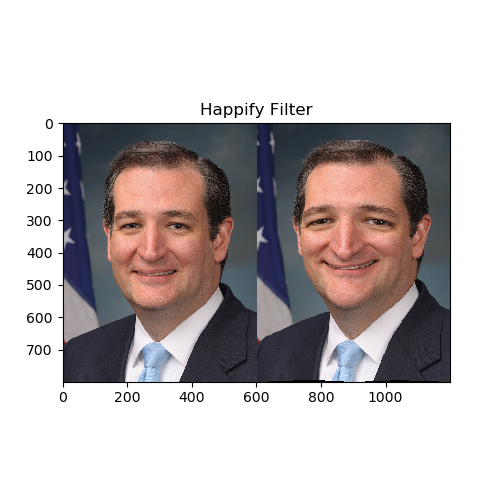

In [15]:
Mat combined;
hconcat(src, dst, combined);
plt::figure_size(500,500);
plt::imshow(combined);
plt::title("Happify Filter");
auto pltImg = displayImage(combined);
pltImg

# <font style = "color:rgb(50,120,229)">References and Further Reading</font>

1. [http://chenxing.name/fun/imgwarp-js/](http://chenxing.name/fun/imgwarp-js/)

2. [http://faculty.cs.tamu.edu/schaefer/research/mls.pdf](http://faculty.cs.tamu.edu/schaefer/research/mls.pdf)